### Chris Hamm 2019-09-23 (initial code)
A jupyter notebook to add *Neonympha* images from **MUSEUM IMAGEs**. 

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%autosave 60

Autosaving every 60 seconds


In [2]:
from fastai import *
from fastai.vision import *

In [3]:
np.random.seed(1138)

Now prepare to download the files to our repo

In [4]:
gimage_path = "../data/images/Museum"

Nar

In [5]:
# Nar_folder = "Nar"
# Nar_file = "Nar_photos.txt"
# Nar_path = Path('../data/images/Museum/Nar')
# Nar_dest = Nar_path/Nar_folder
# Nar_dest.mkdir(parents = True, exist_ok = True)

Nmi

In [6]:
# Nmi_folder = "Nmi"
# Nmi_file = "Nmi_photos.txt"
# Nmi_path = Path('../data/images/Museum/Nmi')
# Nmi_dest = Nmi_path/Nmi_folder
# Nmi_dest.mkdir(parents = True, exist_ok = True)

Nfr

In [7]:
# Nfr_folder = "Nfr"
# Nfr_file = "Nfr_photos.txt"
# Nfr_path = Path('../data/images/Museum/Nfr')
# Nfr_dest = Nfr_path/Nfr_folder
# Nfr_dest.mkdir(parents = True, exist_ok = True)

Nhe

In [8]:
# Nhe_folder = "Nhe"
# Nhe_file = "Nhe_photos.txt"
# Nhe_path = Path('../data/images/Museum/Nhe')
# Nhe_dest = Nhe_path/Nhe_folder
# Nhe_dest.mkdir(parents = True, exist_ok = True)

Download the images

In [9]:
classes = ['Nar', 'Nmi', 'Nfr', 'Nhe']

In [10]:
#download_images(Nar_path/Nar_file, Nar_dest, max_pics = 50)
#download_images(Nmi_path/Nmi_file, Nmi_dest, max_pics = 50)
#download_images(Nfr_path/Nfr_file, Nfr_dest, max_pics = 50)
#download_images(Nhe_path/Nhe_file, Nhe_dest, max_pics = 50)

Commenting the original code while I mess with the progressive resizing

In [11]:
# gimage_data = ImageDataBunch.from_folder(path = gimage_path, train = ".", 
#                                          valid_pct = 0.2, ds_tfms = get_transforms(),
#                                         size = 224, num_workers = 4, bs = 64).normalize(imagenet_stats)

In [12]:
transforms = get_transforms(flip_vert = True, max_warp = 0.1, \
                            max_zoom = 1.05, )

In [13]:
data_64 = ImageDataBunch.from_folder(path = gimage_path, train = ".", 
                                         valid_pct = 0.2, ds_tfms = transforms,
                                        size = 64, num_workers = 4, bs = 64).normalize(imagenet_stats)

In [14]:
data_64

ImageDataBunch;

Train: LabelList (365 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
Nar,Nar,Nar,Nar,Nar
Path: ../data/images/Museum;

Valid: LabelList (91 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
Nmi,Nhe,Nmi,Nmi,Nar
Path: ../data/images/Museum;

Test: None

In [15]:
print(data_64.classes)

['Nar', 'Nfr', 'Nhe', 'Nmi']


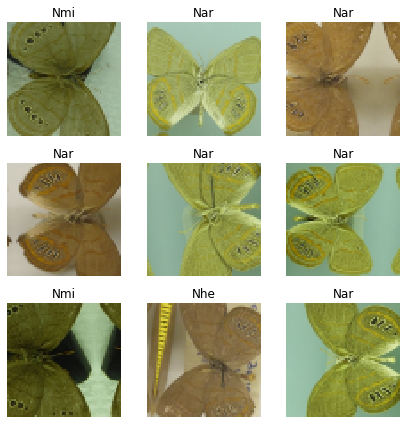

In [16]:
data_64.show_batch(rows = 3, figsize = (6, 6))

### `resnet34`

In [17]:
# with 64 sized images
learn_rn34 = cnn_learner(data_64, \
                            models.resnet34, \
                            metrics = error_rate)

In [18]:
learn_rn34.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


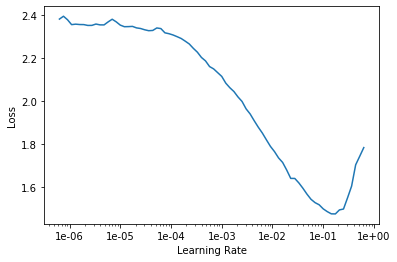

In [19]:
learn_rn34.recorder.plot()

In [20]:
learn_rn34.fit_one_cycle(5, max_lr = slice(1e-03, 1e-02)) 
# with specified LR, get error rate of ~15% after 5 cycles

epoch,train_loss,valid_loss,error_rate,time
0,1.899941,2.562064,0.505495,00:18
1,1.486484,1.887924,0.318681,00:18
2,1.373052,1.546451,0.230769,00:18
3,1.211232,0.970285,0.219780,00:18
4,1.180118,0.576580,0.197802,00:18


In [21]:
learn_rn34.save('stage_1_64_rn34')

In [22]:
#learn_rn34.load('stage_1_64_rn34')

### Now the progressive augmentation

In [23]:
data_128 = ImageDataBunch.from_folder(path = gimage_path, \
                                      train = ".", \
                                      valid_pct = 0.2, \
                                      ds_tfms = transforms, \
                                      size = 128, num_workers = 4, \
                                      bs = 64).normalize(imagenet_stats)

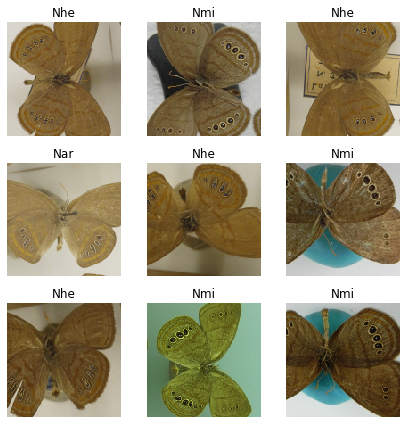

In [24]:
data_128.show_batch(rows = 3, figsize = (6, 6))

In [25]:
learn_rn34.unfreeze()
learn_rn34.data = data_128
learn_rn34.freeze()

In [26]:
learn_rn34.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


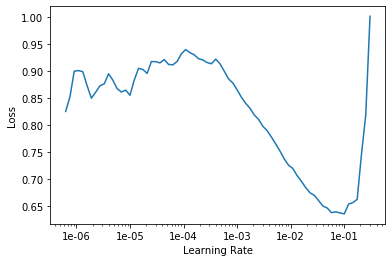

In [27]:
learn_rn34.recorder.plot()

In [28]:
learn_rn34.fit_one_cycle(3, max_lr = slice(1e-03, 1e-02)) # 5% after 2 epochs

epoch,train_loss,valid_loss,error_rate,time
0,0.834189,0.618546,0.153846,00:18
1,0.716006,0.460656,0.131868,00:17
2,0.606859,0.266909,0.087912,00:17


In [29]:
learn_rn34.save('stage_2_128_rn34') 

#### 256 images

In [30]:
data_256 = ImageDataBunch.from_folder(path = gimage_path, \
                                      train = ".", \
                                      valid_pct = 0.2, \
                                      ds_tfms = transforms, \
                                      size = 256, num_workers = 4, \
                                      bs = 32).normalize(imagenet_stats)

In [31]:
learn_rn34.unfreeze()
learn_rn34.data = data_256
learn_rn34.freeze()

In [32]:
learn_rn34.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


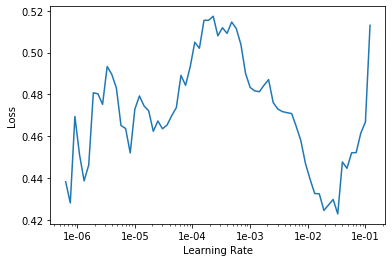

In [33]:
learn_rn34.recorder.plot()

In [34]:
learn_rn34.fit_one_cycle(4, max_lr = slice(1e-03, 1e-02)) # 6% error

epoch,train_loss,valid_loss,error_rate,time
0,0.444618,0.293322,0.087912,00:15
1,0.377410,0.289102,0.076923,00:14
2,0.322247,0.568432,0.109890,00:15
3,0.276625,0.432524,0.098901,00:15


In [35]:
learn_rn34.save('stage_3_256_rn34')

#### Examine problem areas

In [36]:
# It is OK for train loss to be lower than valid loss. That is what you want.
# As long as you are training and error is improving you are not overfitting.

In [37]:
interpretation_34 = ClassificationInterpretation.from_learner(learn_rn34)

losses_34, idxs_34 = interpretation_34.top_losses()

len(data_256.valid_ds) == len(losses_34) == len(idxs_34)

True

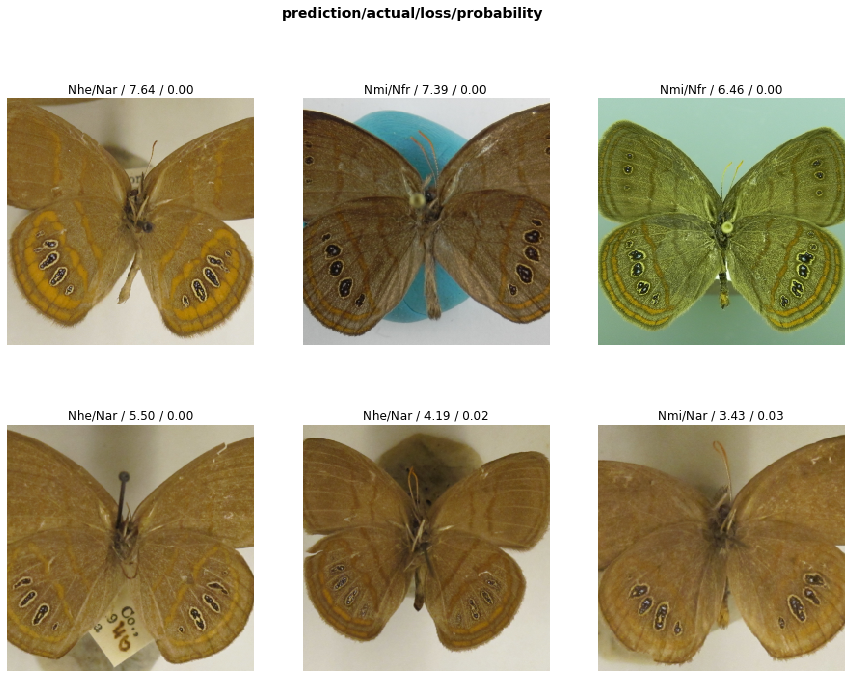

In [38]:
interpretation_34.plot_top_losses(6, figsize = (15, 11))

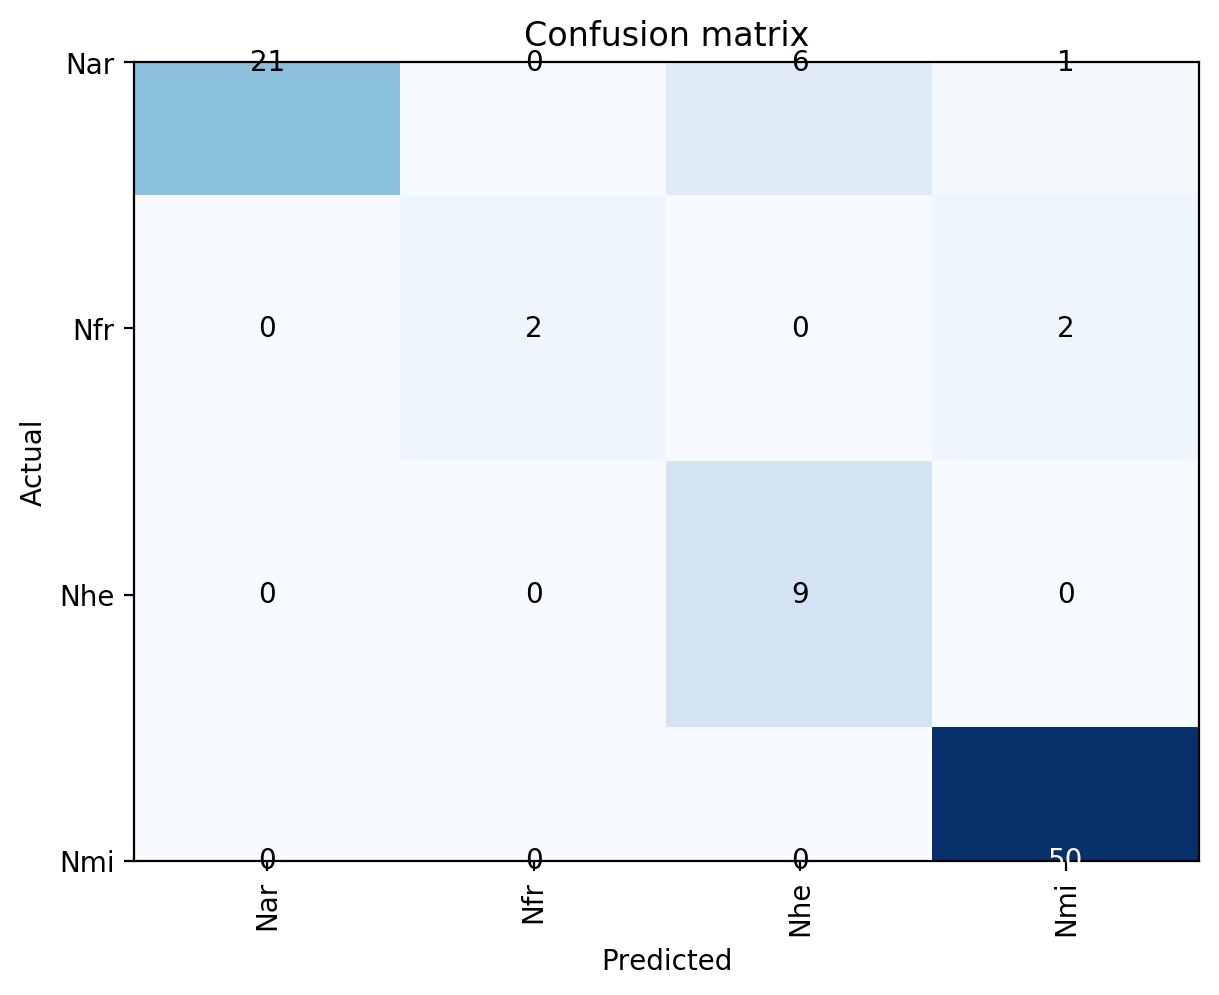

In [39]:
interpretation_34.plot_confusion_matrix(figsize = (6, 6), dpi = 200)

In [40]:
interpretation_34.most_confused(min_val = 0) 

[('Nar', 'Nhe', 6),
 ('Nfr', 'Nmi', 2),
 ('Nar', 'Nmi', 1),
 ('Nar', 'Nar', 0),
 ('Nar', 'Nfr', 0),
 ('Nfr', 'Nar', 0),
 ('Nfr', 'Nfr', 0),
 ('Nfr', 'Nhe', 0),
 ('Nhe', 'Nar', 0),
 ('Nhe', 'Nfr', 0),
 ('Nhe', 'Nhe', 0),
 ('Nhe', 'Nmi', 0),
 ('Nmi', 'Nar', 0),
 ('Nmi', 'Nfr', 0),
 ('Nmi', 'Nhe', 0),
 ('Nmi', 'Nmi', 0)]

### `resnet50`

Re run the code to generate the `data_64` object. 

In [41]:
# with 64 sized images
learn_rn50 = cnn_learner(data_64, \
                            models.resnet50, \
                            metrics = error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:09<00:00, 11.2MB/s]


Get the learning rate

In [42]:
learn_rn50.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


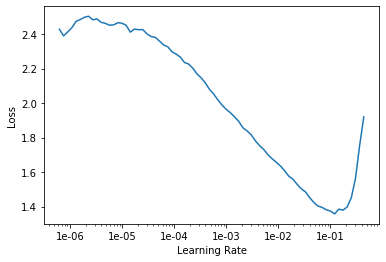

In [43]:
learn_rn50.recorder.plot()

Use the best LR for the model

In [44]:
learn_rn50.fit_one_cycle(4, max_lr = slice(1e-03, 1e-02)) 
# with specified LR, get error rate of ~15% after 4 cycles

epoch,train_loss,valid_loss,error_rate,time
0,1.927196,8.918636,0.472527,00:19
1,1.577678,2.935679,0.296703,00:18
2,1.354161,1.387935,0.241758,00:18
3,1.222052,0.891806,0.186813,00:18


Save the model, fine tune, and save

In [45]:
learn_rn50.save('stage_1_64_rn50')

In [46]:
#learn_rn50.load('stage_1_64_rn50')

Now the progressive augmentation

In [47]:
learn_rn50.unfreeze()
learn_rn50.data = data_128
learn_rn50.freeze()

Find the optimal learning rate

In [48]:
learn_rn50.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


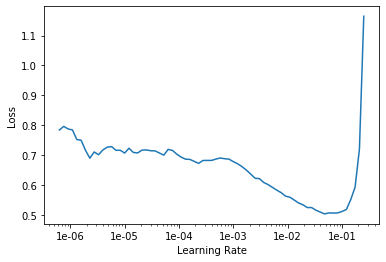

In [49]:
learn_rn50.recorder.plot()

In [50]:
learn_rn50.fit_one_cycle(2, max_lr = slice(1e-03, 1e-02)) # 9% error

epoch,train_loss,valid_loss,error_rate,time
0,0.568974,0.869796,0.197802,00:19
1,0.558933,0.599116,0.164835,00:18


In [51]:
learn_rn50.save('stage_2_128_rn50')

In [52]:
learn_rn50.unfreeze()
learn_rn50.data = data_256
learn_rn50.freeze()

In [53]:
learn_rn50.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


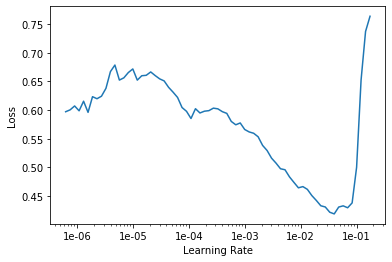

In [54]:
learn_rn50.recorder.plot()

In [55]:
learn_rn50.fit_one_cycle(4) # 6% error

epoch,train_loss,valid_loss,error_rate,time
0,0.577141,0.332630,0.109890,00:17
1,0.414975,0.351906,0.120879,00:16
2,0.352674,0.260315,0.098901,00:16
3,0.293660,0.279309,0.098901,00:16


In [56]:
learn_rn50.save('stage_3_256_rn50')

### Problem areas

In [57]:
interpretation_50 = ClassificationInterpretation.from_learner(learn_rn50)

losses_50, idxs_50 = interpretation_50.top_losses()

len(data_128.valid_ds) == len(losses_50) == len(idxs_50)

True

In [58]:
# learn_rn50.load('stage_3_128_rn50')

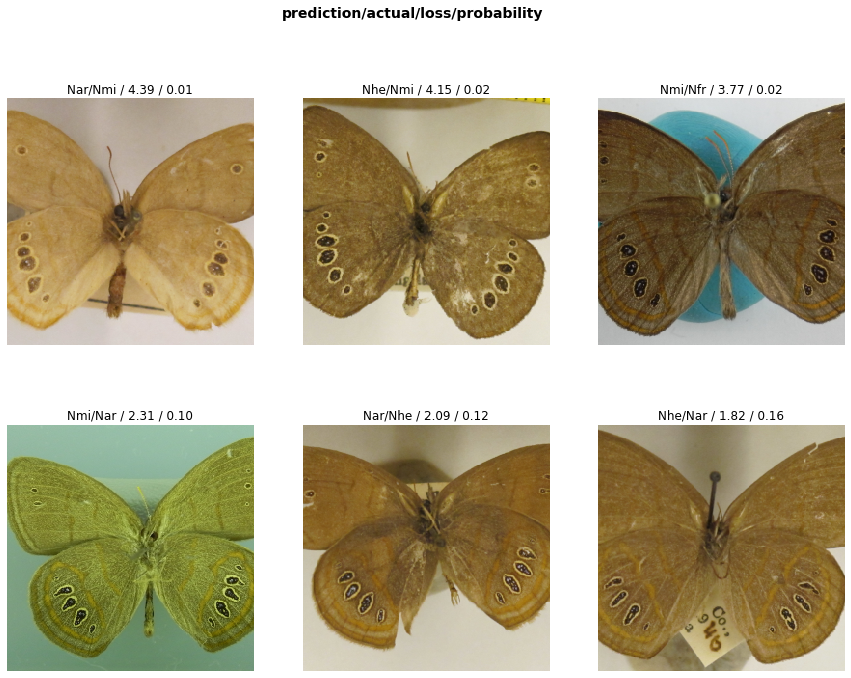

In [59]:
interpretation_50.plot_top_losses(6, figsize = (15, 11))

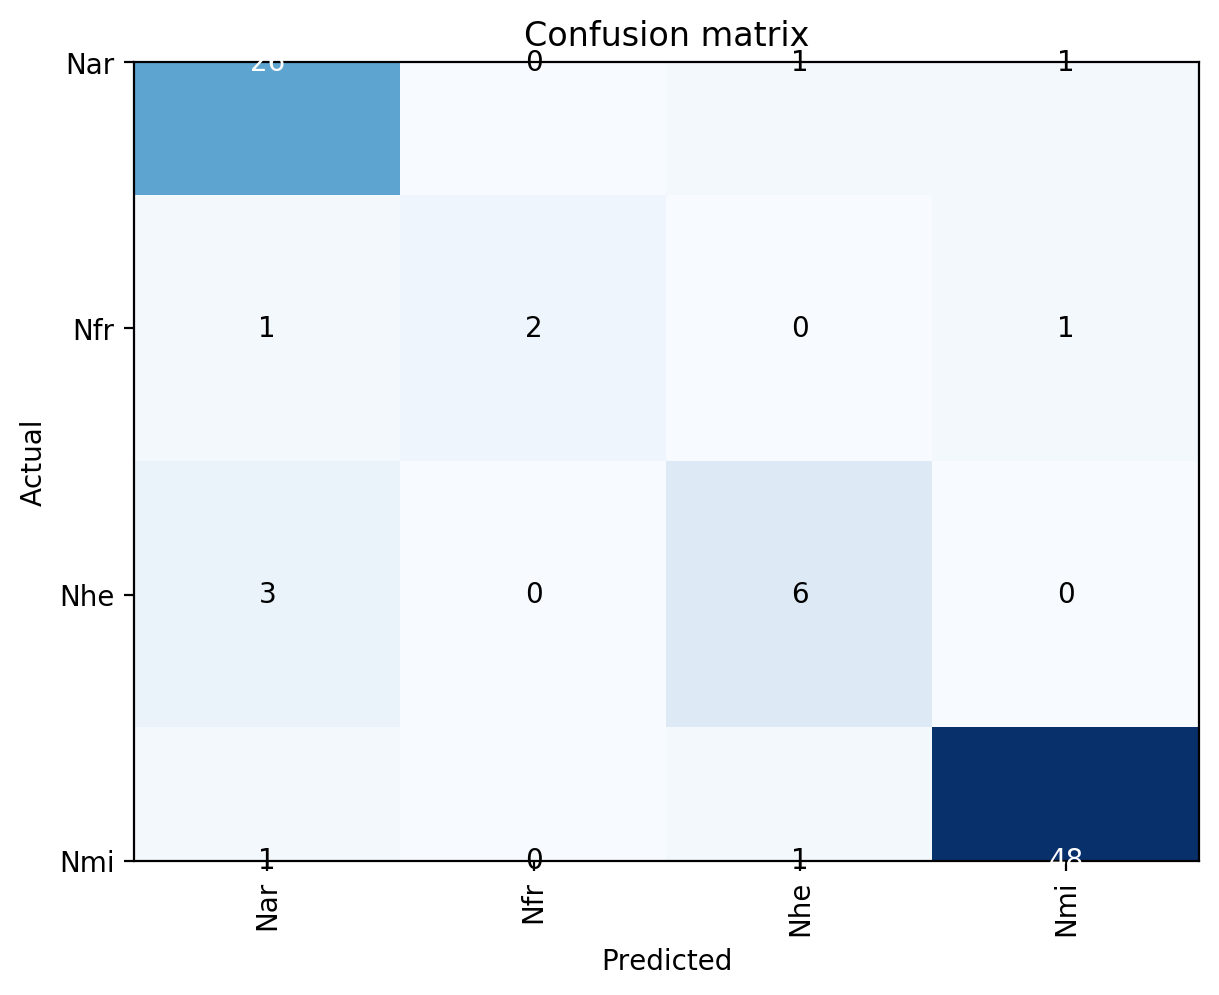

In [60]:
interpretation_50.plot_confusion_matrix(figsize = (6, 6), dpi = 200)

In [61]:
interpretation_50.most_confused(min_val = 0) # same problems as resnet34.

[('Nhe', 'Nar', 3),
 ('Nar', 'Nhe', 1),
 ('Nar', 'Nmi', 1),
 ('Nfr', 'Nar', 1),
 ('Nfr', 'Nmi', 1),
 ('Nmi', 'Nar', 1),
 ('Nmi', 'Nhe', 1),
 ('Nar', 'Nar', 0),
 ('Nar', 'Nfr', 0),
 ('Nfr', 'Nfr', 0),
 ('Nfr', 'Nhe', 0),
 ('Nhe', 'Nfr', 0),
 ('Nhe', 'Nhe', 0),
 ('Nhe', 'Nmi', 0),
 ('Nmi', 'Nfr', 0),
 ('Nmi', 'Nmi', 0)]